# 导入相关软件包

In [1]:
import os
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import mindspore as ms
from mindspore import context
from mindspore.common import set_seed

# 参数配置

In [2]:
def check_device_availability():
    if context.get_context(attr_key='device_target') == "GPU":
        device_target = "GPU"
        context.set_context(mode=context.GRAPH_MODE, device_target="GPU")
    else:
        device_target = "CPU"
        context.set_context(mode=context.GRAPH_MODE, device_target="CPU")
    return device_target

In [3]:
check_device_availability()

'CPU'

In [4]:
# 随机种子
def seed_mindspore(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

In [5]:
config_para = {
    'seed':42,
}

In [6]:
seed_mindspore(seed=config_para['seed'])

# 数据读入

In [7]:
# 西瓜数据集3.0α
data = {
    'id': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17],
    'density': [0.697, 0.774, 0.634, 0.608, 0.556, 0.403, 0.481, 0.437, 0.666, 0.243, 0.245, 0.343, 0.639, 0.657, 0.360, 0.593, 0.719],
    'sugar_rate': [0.460, 0.376, 0.264, 0.318, 0.215, 0.237, 0.149, 0.211, 0.091, 0.267, 0.057, 0.099, 0.161, 0.198, 0.370, 0.042, 0.103],
    'is_good': ['是', '是', '是', '是', '是', '否', '否', '否', '否', '否', '否', '否', '否', '否', '否', '否', '否']
}

In [8]:
# 创建DataFrame
df = pd.DataFrame(data)
df

,id,density,sugar_rate,is_good
0,1,0.697,0.460,是
1,2,0.774,0.376,是
2,3,0.634,0.264,是
3,4,0.608,0.318,是
4,5,0.556,0.215,是
5,6,0.403,0.237,否
6,7,0.481,0.149,否
7,8,0.437,0.211,否
8,9,0.666,0.091,否
9,10,0.243,0.267,否


In [9]:
# 将中文类别映射为数字label
mapping = { # 映射字典
    'is_good': {'否': 0, '是': 1}
}

# 编码
for column, map_dict in mapping.items():
    df[column] = df[column].map(map_dict)
    
# 去除 "编号" 列
df = df.drop(['id'], axis=1)

In [10]:
df

,density,sugar_rate,is_good
0,0.697,0.460,1
1,0.774,0.376,1
2,0.634,0.264,1
3,0.608,0.318,1
4,0.556,0.215,1
5,0.403,0.237,0
6,0.481,0.149,0
7,0.437,0.211,0
8,0.666,0.091,0
9,0.243,0.267,0


# 数据加载和处理

In [11]:
from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import train_test_split

In [12]:
# 分离特征和标签

features = df.drop('is_good', axis=1).to_numpy()
labels = df['is_good'].to_numpy()

In [13]:
features.shape, labels.shape

((17, 2), (17,))

In [14]:
# 特征归一化
scaler = StandardScaler()
features = scaler.fit_transform(features)

In [15]:
# 此时数据仅供训练，不再分割测试集了

# 可视化和探索性数据分析

# SVM实现：libsvm

In [16]:
from libsvm.svmutil import *

In [17]:
x_train = features.tolist() if isinstance(features, np.ndarray) else features
y_train = labels.tolist() if isinstance(labels, np.ndarray) else labels

In [18]:
# 建立模型
prob = svm_problem(y_train, x_train)

In [19]:
# 1. 线性核
param_1 = svm_parameter('-t 0 -c 1')
svm_linear_1 = svm_train(prob, param_1)

In [20]:
# 2. 高斯核
param_2 = svm_parameter('-t 2 -c 1 -g 0.5')
svm_rbf_1 = svm_train(prob, param_2)

In [21]:
# 提取支持向量并对比
linear_support_vectors_1 = svm_linear_1.get_SV()
rbf_support_vectors_1 = svm_rbf_1.get_SV()

print(f"libsvm 线性核：{linear_support_vectors_1}")
print(f"libsvm 高斯核：{rbf_support_vectors_1}")

libsvm 线性核：[{1: 1.4905482969647703, 2: 1.4030719888143706}, {1: 0.6259358312625644, 2: 0.4400406021155382}, {1: 0.46536494477501167, 2: 0.9043593064167609}, {1: 0.14422317179990707, 2: 0.018714370434798854}, {1: 0.656814847894786, 2: -0.4456043338664239}, {1: 0.7679793077707839, 2: -0.12746003647484525}, {1: -1.0662342801831814, 2: 1.3514810216697901}, {1: 1.1508791140103318, 2: -0.9443170162640336}]
libsvm 高斯核：[{1: 1.0150114408285567, 2: 2.125345528838495}, {1: 1.4905482969647703, 2: 1.4030719888143706}, {1: 0.6259358312625644, 2: 0.4400406021155382}, {1: 0.46536494477501167, 2: 0.9043593064167609}, {1: 0.14422317179990707, 2: 0.018714370434798854}, {1: -0.5906974240469682, 2: -0.01567960766158805}, {1: -1.776451662724279, 2: -1.3398477643724827}, {1: 0.656814847894786, 2: -0.4456043338664239}, {1: 0.7679793077707839, 2: -0.12746003647484525}, {1: -1.0662342801831814, 2: 1.3514810216697901}]


# SVM实现：sklearn

In [22]:
from sklearn.svm import SVC

In [23]:
# 1. 线性核
svm_linear_2 = SVC(kernel='linear')
svm_linear_2.fit(features, labels)

SVC(kernel='linear')

In [24]:
# 2. 高斯核
svm_rbf_2 = SVC(kernel='rbf', gamma='scale')
svm_rbf_2.fit(features, labels)

SVC()

In [25]:
# 提取支持向量并对比
linear_support_vectors_2 = svm_linear_2.support_vectors_
rbf_support_vectors_2 = svm_rbf_2.support_vectors_

print(f"sklearn 线性核：{linear_support_vectors_2}")
print(f"sklearn 高斯核：{rbf_support_vectors_2}")

sklearn 线性核：[[ 0.65681485 -0.44560433]
 [ 0.76797931 -0.12746004]
 [-1.06623428  1.35148102]
 [ 1.15087911 -0.94431702]
 [ 1.4905483   1.40307199]
 [ 0.62593583  0.4400406 ]
 [ 0.46536494  0.90435931]
 [ 0.14422317  0.01871437]]
sklearn 高斯核：[[-0.59069742 -0.01567961]
 [-1.77645166 -1.33984776]
 [ 0.65681485 -0.44560433]
 [ 0.76797931 -0.12746004]
 [-1.06623428  1.35148102]
 [ 1.01501144  2.12534553]
 [ 1.4905483   1.40307199]
 [ 0.62593583  0.4400406 ]
 [ 0.46536494  0.90435931]
 [ 0.14422317  0.01871437]]


# SVM实现：MindSpore

In [26]:
from mindspore import Tensor, Parameter, nn, ops

In [27]:
# 设置运行模式（动态图适合调试）
context.set_context(mode=context.PYNATIVE_MODE)

In [28]:
# 因为mindspore里没有svm，这里自定义了一个，并使用mindspore的tensor
class SVM(nn.Cell):
    def __init__(self, n_features, kernel='linear', gamma=1.0):
        super(SVM, self).__init__()
        self.kernel = kernel
        self.gamma = gamma
        self.w = Parameter(Tensor(np.random.randn(n_features, 1).astype(np.float32)), name="w")  # 随机初始化
        self.b = Parameter(Tensor(np.random.randn(1).astype(np.float32)), name="b")  # 随机初始化

    def kernel_function(self, X, Y):
        if self.kernel == 'linear':
            return ops.MatMul()(X, Y.T)
        elif self.kernel == 'rbf':
            X_norm = ops.ReduceSum(keep_dims=True)(ops.Pow()(X, 2), axis=1)
            Y_norm = ops.ReduceSum(keep_dims=True)(ops.Pow()(Y, 2), axis=1)
            XY = ops.MatMul()(X, Y.T)
            return ops.Exp()(-self.gamma * (X_norm - 2 * XY + Y_norm.T))
        else:
            raise ValueError("Unsupported kernel type")

    def construct(self, X):
        return ops.MatMul()(X, self.w) + self.b
    
# Convert data to MindSpore tensors
X_train_tensor = Tensor(features, dtype=ms.float32)
y_train_tensor = Tensor(np.where(labels == 0, -1, 1)[:, None], dtype=ms.float32)

In [29]:
# 1. 线性核
svm_linear_3 = SVM(n_features=2, kernel='linear')
optimizer_linear = nn.SGD(params=svm_linear_3.trainable_params(), learning_rate=0.01)
loss_fn_linear = nn.WithLossCell(svm_linear_3,loss_fn=nn.MSELoss(reduction='mean'))  # 使用 Mean 操作，将 MSELoss 输出的张量压缩为标量

# 使用 TrainOneStepCell 将前向传播、反向传播和优化器结合
train_step = nn.TrainOneStepCell(loss_fn_linear, optimizer_linear)
train_step.set_train()

for epoch in range(1000):
    loss = train_step(X_train_tensor, y_train_tensor)
    print(f"Epoch {epoch + 1}, Loss: {loss}")
    print(f"Weight w: {svm_linear_3.w.asnumpy().flatten()}, Bias b: {svm_linear_3.b.asnumpy()}")

Epoch 1, Loss: 3.1184194
Weight w: [-1.0820893   0.32838973], Bias b: [0.26522517]
Epoch 2, Loss: 3.0028596
Weight w: [-1.0529315   0.33757082], Bias b: [0.25168538]
Epoch 3, Loss: 2.892303
Weight w: [-1.0243928   0.34645405], Bias b: [0.23841637]
Epoch 4, Loss: 2.786528
Weight w: [-0.9964598   0.35504782], Bias b: [0.22541276]
Epoch 5, Loss: 2.6853254
Weight w: [-0.9691191   0.36336026], Bias b: [0.21266921]
Epoch 6, Loss: 2.5884922
Weight w: [-0.9423577   0.37139934], Bias b: [0.20018053]
Epoch 7, Loss: 2.495837
Weight w: [-0.9161631  0.3791728], Bias b: [0.18794163]
Epoch 8, Loss: 2.4071753
Weight w: [-0.8905228   0.38668817], Bias b: [0.1759475]
Epoch 9, Loss: 2.3223324
Weight w: [-0.86542475  0.39395276], Bias b: [0.16419326]
Epoch 10, Loss: 2.24114
Weight w: [-0.84085715  0.40097374], Bias b: [0.1526741]
Epoch 11, Loss: 2.1634376
Weight w: [-0.8168084   0.40775806], Bias b: [0.14138532]
Epoch 12, Loss: 2.0890727
Weight w: [-0.7932672   0.41431245], Bias b: [0.13032232]
Epoch 13, 

In [30]:
# 2. 高斯核
svm_rbf_3 = SVM(n_features=2, kernel='rbf', gamma=0.5)
optimizer_rbf = nn.SGD(params=svm_rbf_3.trainable_params(), learning_rate=0.01)
loss_fn_rbf = nn.WithLossCell(svm_rbf_3,loss_fn=nn.MSELoss(reduction='mean'))  # 使用 Mean 操作，将 MSELoss 输出的张量压缩为标量

# 使用 TrainOneStepCell 将前向传播、反向传播和优化器结合
train_step = nn.TrainOneStepCell(loss_fn_rbf, optimizer_rbf)
train_step.set_train()

for epoch in range(1000):
    loss = train_step(X_train_tensor, y_train_tensor)
    print(f"Epoch {epoch + 1}, Loss: {loss}")
    print(f"Weight w: {svm_rbf_3.w.asnumpy().flatten()}, Bias b: {svm_rbf_3.b.asnumpy()}")

Epoch 1, Loss: 1.7509526
Weight w: [ 1.0013833  -0.56171006], Bias b: [-0.5229017]
Epoch 2, Loss: 1.7057446
Weight w: [ 0.99235886 -0.5428896 ], Bias b: [-0.520679]
Epoch 3, Loss: 1.6620594
Weight w: [ 0.9834412 -0.5244102], Bias b: [-0.5185007]
Epoch 4, Loss: 1.6198448
Weight w: [ 0.9746294 -0.5062654], Bias b: [-0.51636595]
Epoch 5, Loss: 1.5790498
Weight w: [ 0.9659228  -0.48844898], Bias b: [-0.51427394]
Epoch 6, Loss: 1.5396261
Weight w: [ 0.9573205  -0.47095478], Bias b: [-0.5122238]
Epoch 7, Loss: 1.5015265
Weight w: [ 0.9488217  -0.45377678], Bias b: [-0.5102146]
Epoch 8, Loss: 1.4647055
Weight w: [ 0.94042563 -0.43690902], Bias b: [-0.50824565]
Epoch 9, Loss: 1.4291198
Weight w: [ 0.9321314  -0.42034572], Bias b: [-0.506316]
Epoch 10, Loss: 1.3947268
Weight w: [ 0.92393816 -0.40408123], Bias b: [-0.504425]
Epoch 11, Loss: 1.3614858
Weight w: [ 0.91584504 -0.3881099 ], Bias b: [-0.50257176]
Epoch 12, Loss: 1.3293576
Weight w: [ 0.9078512 -0.3724263], Bias b: [-0.5007556]
Epoch 

In [42]:
# 支持向量筛选函数
def find_support_vectors(model, X, y, kernel='linear', gamma=1.0, tolerance=1e-3):
    """
    Enhanced support vector selection function
    Args:
        model: Trained SVM model
        X: Input features (MindSpore tensor)
        y: Labels (MindSpore tensor)
        kernel: Kernel type ('linear' or 'rbf')
        gamma: RBF kernel parameter
        tolerance: Numerical tolerance for identifying support vectors
    Returns:
        support_indices: Indices of identified support vectors
        support_vectors: Feature values of support vectors
    """
    X_np = X.asnumpy()
    y_np = y.asnumpy()

    if kernel == 'linear':
        # Calculate decision values using the primal form
        w_np = model.w.asnumpy()
        b_np = model.b.asnumpy()
        decision_values = np.dot(X_np, w_np) + b_np
        
        # Calculate functional margins
        margins = y_np.flatten() * decision_values.flatten()
        
        # Identify support vectors using the KKT conditions
        support_indices = np.where(np.abs(np.abs(margins) - 1) < tolerance)[0]
        
    elif kernel == 'rbf':
        # Calculate the gram matrix
        X_norm = np.sum(np.square(X_np), axis=1, keepdims=True)
        gram_matrix = np.exp(-gamma * (X_norm - 2 * np.dot(X_np, X_np.T) + X_norm.T))
        
        # Calculate decision values
        decision_values = model(Tensor(X_np, dtype=ms.float32)).asnumpy()
        margins = y_np.flatten() * decision_values.flatten()
        
        # Use stricter conditions for RBF kernel
        support_indices = np.where(
            (np.abs(margins - 1) < tolerance) |  # On margin
            ((margins < 1) & (margins > 0))      # Inside margin (soft margin case)
        )[0]
    
    else:
        raise ValueError("Unsupported kernel type")

    support_vectors = X_np[support_indices]
    
    return support_indices, support_vectors


_, linear_support_vectors_3 = find_support_vectors(
    svm_linear_3, X_train_tensor, y_train_tensor, kernel='linear', tolerance=1e-1
)
_, rbf_support_vectors_3 = find_support_vectors(
    svm_rbf_3, X_train_tensor, y_train_tensor, kernel='rbf', gamma=0.5, tolerance=1e-3
)

print(f"mindspore 线性核：{linear_support_vectors_3}")
print(f"mindspore 高斯核：{rbf_support_vectors_3}")

mindspore 线性核：[[ 1.0150114  2.1253455]
 [ 0.3727279 -1.4688252]]
mindspore 高斯核：[[ 1.4905483   1.403072  ]
 [ 0.62593585  0.4400406 ]
 [ 0.46536493  0.9043593 ]
 [-0.80067474  0.20788126]
 [-0.31896207 -0.5487863 ]
 [-0.5906974  -0.01567961]
 [ 0.82356155 -1.047499  ]
 [-1.7888032   0.46583608]
 [ 0.6568149  -0.44560432]
 [ 0.7679793  -0.12746003]
 [-1.0662342   1.3514811 ]
 [ 1.1508791  -0.94431704]]


# 更细致的评估和分析

## 可视化

In [32]:
def get_decision_function(implementation, model, kernel_type, X):
    """
    Get decision function values for different SVM implementations
    """
    if implementation == 'libsvm':
        if kernel_type == 'linear':
            p_label, _, p_val = svm_predict([0] * len(X), X.tolist(), model)
            return np.array(p_val).flatten()
        else:  # rbf kernel
            p_label, _, p_val = svm_predict([0] * len(X), X.tolist(), model)
            return np.array(p_val).flatten()
            
    elif implementation == 'sklearn':
        return model.decision_function(X)
        
    else:  # mindspore
        X_tensor = Tensor(X, dtype=ms.float32)
        return model(X_tensor).asnumpy().flatten()

def preprocess_support_vectors(sv_data):
    """
    预处理支持向量数据，确保格式统一
    Args:
        sv_data: 原始支持向量数据
    Returns:
        处理后的支持向量数组
    """
    if isinstance(sv_data, list):  # 处理 libsvm 的输出
        return scaler.inverse_transform([[sv.get(i+1, 0) for i in range(2)] for sv in sv_data])
    return sv_data

def plot_decision_boundary(ax, implementation, model, X, kernel_type, scaler):
    """
    绘制决策边界和间隔边界
    Args:
        ax: matplotlib轴对象
        model: SVM模型
        X: 特征数据
        kernel_type: 核函数类型
        scaler: 标准化对象
    """
    # 在原始空间创建网格
    raw_X = scaler.inverse_transform(X)
    x_min, x_max = raw_X[:, 0].min() - 0.1, raw_X[:, 0].max() + 0.1
    y_min, y_max = raw_X[:, 1].min() - 0.1, raw_X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                        np.linspace(y_min, y_max, 100))
    
    # 将网格转换到缩放空间进行预测
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    scaled_grid = scaler.transform(grid_points)
    
    # 计算决策函数值
    Z = get_decision_function(implementation, model, kernel_type, scaled_grid)
    Z = Z.reshape(xx.shape)
    
    # 绘制决策边界和间隔
    ax.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])

def find_closest_points(raw_features, sv_points):
    """
    找到离支持向量最近的原始数据点
    Args:
        raw_features: 原始特征数据
        sv_points: 支持向量点
    Returns:
        最近点的索引列表
    """
    closest_indices = []
    for sv in sv_points:
        distances = np.linalg.norm(raw_features - sv, axis=1)
        closest_indices.append(np.argmin(distances))
    return np.unique(closest_indices)

def plot_svm_comparison(features, labels, svms_dict, models_dict):
    """
    绘制SVM比较图，包括决策边界和支持向量
    Args:
        features: 特征数据
        labels: 标签
        svms_dict: 包含不同实现支持向量的字典
    """
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    titles = ['LibSVM Linear', 'Sklearn Linear', 'MindSpore Linear',
             'LibSVM Gaussian', 'Sklearn Gaussian', 'MindSpore Gaussian']
    
    implementations = list(svms_dict.keys())
    raw_features = scaler.inverse_transform(features)
    good_indices = labels == 1
    bad_indices = labels == 0
    
    # # 创建和训练sklearn模型用于决策边界
    # svm_linear = SVC(kernel='linear')
    # svm_rbf = SVC(kernel='rbf', gamma='scale')
    # svm_linear.fit(features, labels)
    # svm_rbf.fit(features, labels)
    
    for i in range(2):  # 行（核函数类型）
        for j in range(3):  # 列（实现方式）
            ax = axes[i, j]
            implementation = implementations[j]
            sv_dict = svms_dict[implementation]
            model = models_dict[implementation][i]  # Get corresponding model
            
            # 绘制决策边界
            kernel_type = 'linear' if i == 0 else 'rbf'
            plot_decision_boundary(ax, implementation, model, features, 
                                kernel_type, scaler)
            
            # 绘制原始数据点
            ax.scatter(raw_features[good_indices, 0], raw_features[good_indices, 1], 
                      c='g', marker='o', label='good melon (is_good=1)')
            ax.scatter(raw_features[bad_indices, 0], raw_features[bad_indices, 1], 
                      c='r', marker='x', label='bad melon (is_good=0)')
            
            # 标注支持向量
            kernel_type = 'linear' if i == 0 else 'rbf'
            if kernel_type in sv_dict:
                sv_points = preprocess_support_vectors(sv_dict[kernel_type])
                if implementation != 'sklearn':
                    sv_points = scaler.inverse_transform(sv_points)
                
                # 找到并标注最近的原始数据点
                sv_indices = find_closest_points(raw_features, sv_points)
                for idx in sv_indices:
                    ax.add_patch(plt.Circle(raw_features[idx], 
                                          radius=0.02, fill=False,
                                          color='b' if i == 0 else 'purple', 
                                          linestyle='--'))
            
            ax.set_title(titles[i * 3 + j])
            ax.set_xlabel('density')
            ax.set_ylabel('sugar_rate')
            ax.legend()
    
    plt.tight_layout()
    plt.show()

def verify_support_vectors(model, X, y, sv_indices):
    """
    验证支持向量的正确性
    Args:
        model: 训练好的SVM模型（sklearn实现）
        X: 缩放后的特征数据
        y: 标签
        sv_indices: 支持向量的索引
    Returns:
        包含验证结果的字典
    """
    verification_results = {
        'total_sv': len(sv_indices),
        'on_margin': 0,
        'margin_distances': []
    }
    
    if hasattr(model, 'decision_function'):
        margins = abs(model.decision_function(X[sv_indices]))
        verification_results['margin_distances'] = margins
        verification_results['on_margin'] = np.sum(np.isclose(margins, 1.0, atol=1e-3))
        verification_results['percentage_on_margin'] = (verification_results['on_margin'] / 
                                                      verification_results['total_sv'] * 100)
    
    return verification_results

Accuracy = 73.78% (7378/10000) (classification)
Accuracy = 74.47% (7447/10000) (classification)


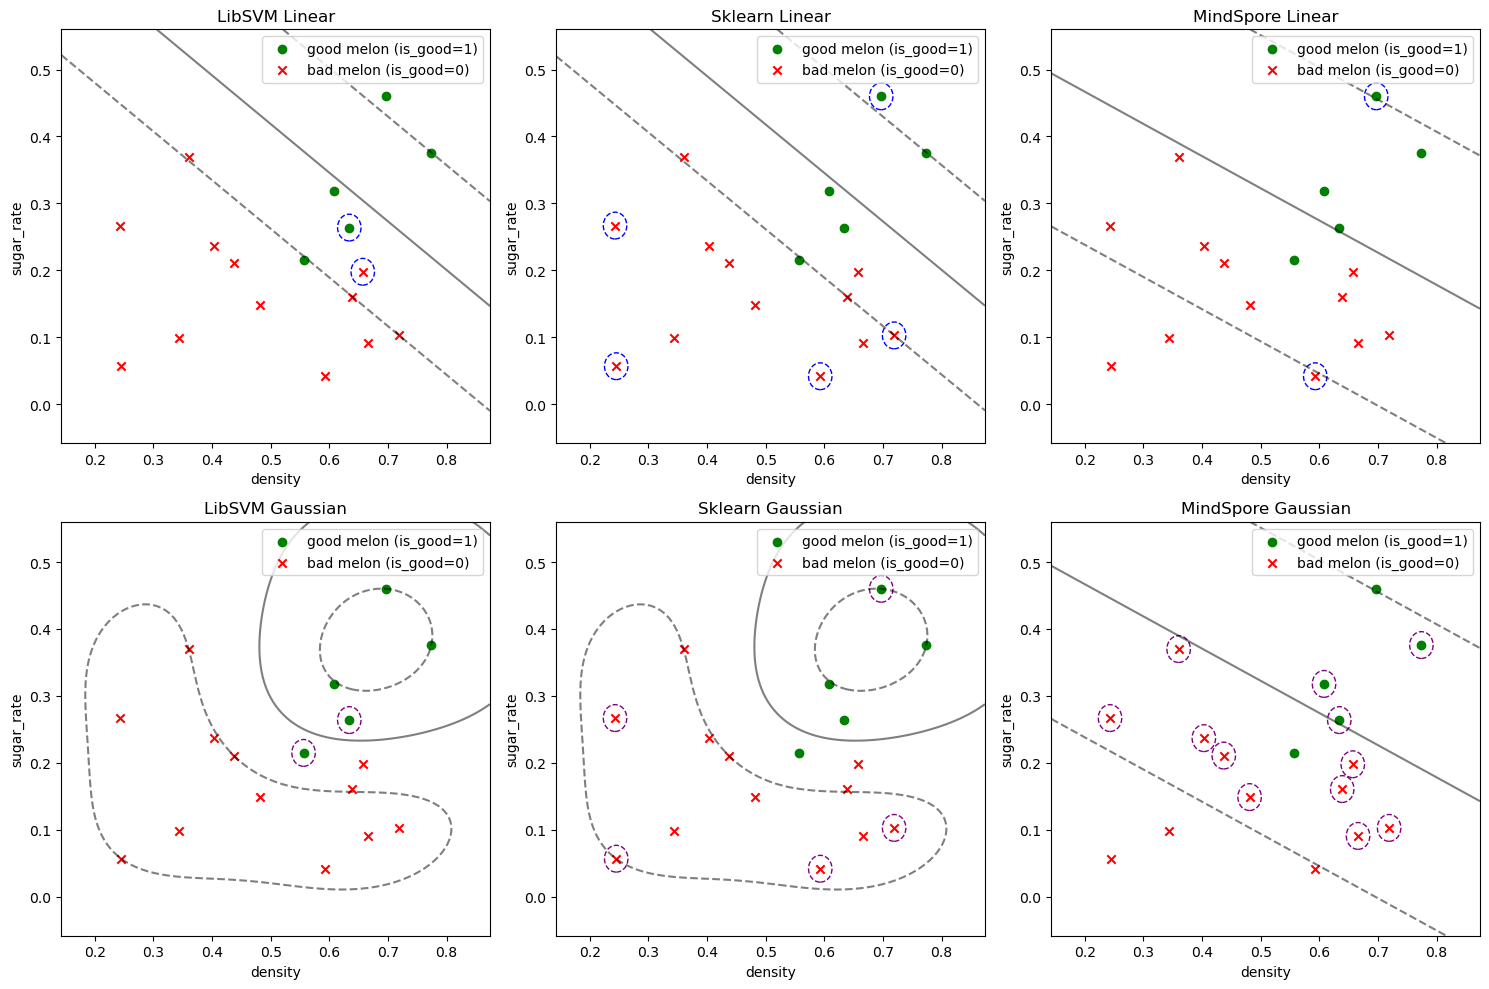

In [43]:
# 准备支持向量数据
svms_dict = {
    'libsvm': {
        'linear': linear_support_vectors_1,
        'rbf': rbf_support_vectors_1
    },
    'sklearn': {
        'linear': linear_support_vectors_2,
        'rbf': rbf_support_vectors_2
    },
    'mindspore': {
        'linear': linear_support_vectors_3,
        'rbf': rbf_support_vectors_3
    }
}

models_dict = {
    'libsvm': {
        0: svm_linear_1,  # Linear kernel model
        1: svm_rbf_1      # RBF kernel model
    },
    'sklearn': {
        0: svm_linear_2,
        1: svm_rbf_2
    },
    'mindspore': {
        0: svm_linear_3,
        1: svm_rbf_3
    }
}

# 绘制比较图
plot_svm_comparison(features, labels, svms_dict, models_dict)

# # 验证sklearn实现的支持向量
# if you_want_to_verify:
#     svm_linear = SVC(kernel='linear')
#     svm_linear.fit(features, labels)
#     verification_results = verify_support_vectors(svm_linear, features, labels, svm_linear.support_)
#     print("Support Vector Verification Results:")
#     print(f"Total support vectors: {verification_results['total_sv']}")
#     print(f"Support vectors on margin: {verification_results['on_margin']}")
#     print(f"Percentage on margin: {verification_results['percentage_on_margin']:.2f}%")

## 交叉验证

In [34]:
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [35]:
def evaluate_svm_loocv(X, y, model_name, kernel_type):
    """
    使用留一交叉验证评估SVM模型性能
    Args:
        X: 特征数据
        y: 标签
        model_name: 模型实现方式 ('libsvm', 'sklearn', 或 'mindspore')
        kernel_type: 核函数类型 ('linear' 或 'rbf')
    Returns:
        包含评估指标的字典
    """
    loo = LeaveOneOut()
    predictions = []
    
    for train_idx, test_idx in loo.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        if model_name == 'libsvm':
            prob = svm_problem(y_train.tolist(), X_train.tolist())
            if kernel_type == 'linear':
                param = svm_parameter('-t 0 -c 1')
            else:  # rbf
                param = svm_parameter('-t 2 -c 1 -g 0.5')
            model = svm_train(prob, param)
            p_label, _, _ = svm_predict(y_test.tolist(), X_test.tolist(), model)
            predictions.extend(p_label)
        
        elif model_name == 'sklearn':
            if kernel_type == 'linear':
                model = SVC(kernel='linear')
            else:  # rbf
                model = SVC(kernel='rbf', gamma='scale')
            model.fit(X_train, y_train)
            predictions.extend(model.predict(X_test))
        
        else:  # mindspore
            if kernel_type == 'linear':
                model = SVM(n_features=2, kernel='linear')
                optimizer = nn.SGD(model.trainable_params(), learning_rate=0.01)
            else:
                model = SVM(n_features=2, kernel='rbf', gamma=0.5)
                optimizer = nn.SGD(model.trainable_params(), learning_rate=0.01)
            
            # MindSpore模型训练和预测
            X_train_tensor = Tensor(X_train, dtype=ms.float32)
            y_train_tensor = Tensor(np.where(y_train == 0, -1, 1)[:, None], dtype=ms.float32)
            
            loss_fn = nn.MSELoss(reduction='mean')
            loss_net = nn.WithLossCell(backbone=model, loss_fn=loss_fn)
            train_step = nn.TrainOneStepCell(loss_net, optimizer)
            
            # 训练过程
            for _ in range(1000):
                train_step(X_train_tensor, y_train_tensor)
            
            # 预测
            X_test_tensor = Tensor(X_test, dtype=ms.float32)
            pred = model(X_test_tensor)
            predictions.extend([1 if p > 0 else 0 for p in pred.asnumpy()])
    
    # 计算评估指标
    metrics = {
        'accuracy': accuracy_score(y, predictions),
        'precision': precision_score(y, predictions),
        'recall': recall_score(y, predictions),
        'f1': f1_score(y, predictions)
    }
    
    return metrics

In [36]:
# 使用示例
implementations = ['libsvm', 'sklearn', 'mindspore']
kernels = ['linear', 'rbf']

results = {}
for impl in implementations:
    results[impl] = {}
    for kernel in kernels:
        metrics = evaluate_svm_loocv(features, labels, impl, kernel)
        results[impl][kernel] = metrics

# 打印评估结果
for impl in results:
    print(f"\n{impl} Implementation:")
    for kernel, metrics in results[impl].items():
        print(f"\n{kernel} kernel:")
        for metric, value in metrics.items():
            print(f"{metric}: {value:.4f}")

Accuracy = 100% (1/1) (classification)
Accuracy = 100% (1/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 100% (1/1) (classification)
Accuracy = 100% (1/1) (classification)
Accuracy = 100% (1/1) (classification)
Accuracy = 100% (1/1) (classification)
Accuracy = 100% (1/1) (classification)
Accuracy = 100% (1/1) (classification)
Accuracy = 100% (1/1) (classification)
Accuracy = 100% (1/1) (classification)
Accuracy = 100% (1/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 100% (1/1) (classification)
Accuracy = 100% (1/1) (classification)
Accuracy = 100% (1/1) (classification)
Accuracy = 100% (1/1) (classification)
Accuracy = 100% (1/1) (classification)
Accuracy = 100% (1/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 100% (1/1) (classification)
Accuracy = 100% (1/1) (classification)
Accuracy = 100% (1/1) (classification)
Accuracy = 100% (1/1) (classificati

## 分析支持向量分布特征

In [37]:
def analyze_support_vectors(sv_dict):
    """
    分析支持向量的统计特征和分布特征
    Args:
        sv_dict: 包含不同实现方法支持向量的字典
    Returns:
        包含支持向量分析结果的字典
    """
    sv_analysis = {}
    
    for implementation, kernels in sv_dict.items():
        sv_analysis[implementation] = {}
        for kernel_type, sv in kernels.items():
            # 预处理支持向量数据
            sv = preprocess_support_vectors(sv)
            
            # 基础统计特征
            basic_stats = {
                'support_vector_count': len(sv),
                'density_mean': np.mean(sv[:, 0]),
                'density_std': np.std(sv[:, 0]),
                'sugar_rate_mean': np.mean(sv[:, 1]),
                'sugar_rate_std': np.std(sv[:, 1])
            }
            
            # 支持向量的空间分布特征
            spatial_stats = {
                'density_range': np.ptp(sv[:, 0]),  # 密度范围
                'sugar_rate_range': np.ptp(sv[:, 1]),  # 含糖率范围
                'spatial_density': len(sv) / (np.ptp(sv[:, 0]) * np.ptp(sv[:, 1])),  # 空间密度
                'correlation': np.corrcoef(sv[:, 0], sv[:, 1])[0, 1]  # 特征相关性
            }
            
            sv_analysis[implementation][kernel_type] = {
                **basic_stats,
                **spatial_stats
            }
    
    return sv_analysis

In [38]:
# 使用示例
sv_analysis_results = analyze_support_vectors(svms_dict)

# 打印分析结果
for impl in sv_analysis_results:
    print(f"\n{impl} Implementation:")
    for kernel, stats in sv_analysis_results[impl].items():
        print(f"\n{kernel} kernel:")
        for stat, value in stats.items():
            if isinstance(value, (int, np.integer)):
                print(f"{stat}: {value}")
            else:
                print(f"{stat}: {value:.4f}")


libsvm Implementation:

linear kernel:
support_vector_count: 8
density_mean: 0.6184
density_std: 0.1158
sugar_rate_mean: 0.2506
sugar_rate_std: 0.0926
density_range: 0.4140
sugar_rate_range: 0.2730
spatial_density: 70.7827
correlation: -0.3304

rbf kernel:
support_vector_count: 10
density_mean: 0.5607
density_std: 0.1557
sugar_rate_mean: 0.2630
sugar_rate_std: 0.1132
density_range: 0.5290
sugar_rate_range: 0.4030
spatial_density: 46.9072
correlation: 0.5085

sklearn Implementation:

linear kernel:
support_vector_count: 8
density_mean: 0.5294
density_std: 0.7151
sugar_rate_mean: 0.3250
sugar_rate_std: 0.7960
density_range: 2.5568
sugar_rate_range: 2.3474
spatial_density: 1.3329
correlation: -0.3304

rbf kernel:
support_vector_count: 10
density_mean: 0.1732
density_std: 0.9614
sugar_rate_mean: 0.4314
sugar_rate_std: 0.9733
density_range: 3.2670
sugar_rate_range: 3.4652
spatial_density: 0.8833
correlation: 0.5085

mindspore Implementation:

linear kernel:
support_vector_count: 12
density